# Reproducibility - DCM_HCM (RNA)

In [1]:
from modules.MIRACLE import MIRACLE, create_data
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
data = [create_data('./data/processed/dcm_hcm_1/')]
miracle = MIRACLE(data, ['current'])
MIRACLE.init_model('denovo')
MIRACLE.train(n_epoch=2000, save_dir='./result/dcm_hcm_1/train')
MIRACLE.predict('./result/dcm_hcm_1/predict')
MIRACLE.pack('dcm_hcm_pack', './data/processed/', n_sample=50000)

In [ ]:
for i in range(2,43):
    data = [create_data('./data/processed/dcm_hcm_pack/'), create_data('./data/processed/dcm_hcm_%d/'%i)]
    status = ['replay', 'current']
    miracle = MIRACLE(data, status)
    MIRACLE.init_model('continual',model_path='./result/dcm_hcm_%d/train/sp_latest.pt'%(i-1))
    MIRACLE.train(n_epoch=2000, save_dir='./result/dcm_hcm_%d/train'%i)
    MIRACLE.predict('./result/dcm_hcm_%d/predict'%i)
    MIRACLE.pack('dcm_hcm_pack_', './data/processed/',n_sample=50000)
    os.removedirs('./data/processed/dcm_hcm_pack')
    os.rename('./data/processed/dcm_hcm_pack_', './data/processed/dcm_hcm_pack')

In [8]:
data = [create_data('/dev/shm/processed/dcm_hcm_%d/'%i) for i in range(1,43)]
miracle= MIRACLE(data, ['current'] * len(data))
miracle.init_model('denovo',model_path='./result/dcm_hcm_42/train/sp_latest.pt')

load a pretrained model from ../MIRACLE/result/dcm_hcm/bts_50000_new_41/default/train/sp_latest.pt
Parameter number: 8.672 M


In [ ]:
miracle.predict('./result/dcm_hcm/predict')

In [22]:
emb = miracle.read_embeddings()
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata.obs_names = [i.split('_')[1] for i in np.concatenate([d.cell_names['subset_0'] for d in data])]

label = pd.DataFrame([])
for p in os.listdir('../MIRACLE/data/raw/dcm_hcm'):
    if 'P' in p:
        label = pd.concat([label, pd.read_csv("/".join(['./data/raw/dcm_hcm',p,'label_seurat','l1.csv']), index_col=0)])
adata.obs['batch'] = emb["s"]["joint"].astype('str')
adata.obs['label'] = label


In [30]:
adata.obs['batch'] = emb["s"]["joint"].astype('str')
adata.obs['label'] = label

/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/test_env3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


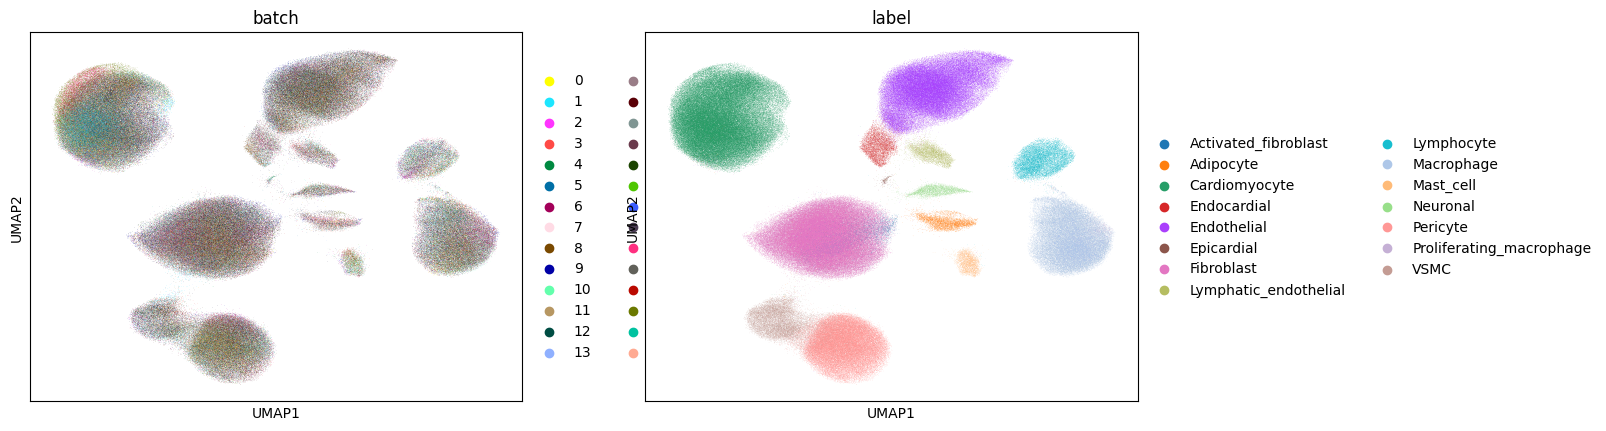

In [33]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'label'])